# **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt

# **Colab Configuration**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Augmentation**

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Dataset & Dataloader**

In [ ]:
train_dataset = datasets.ImageFolder('drive/MyDrive/Deep Learning/15 - Transfer Learning/dataset cacing/train', transform=train_transform)
test_dataset = datasets.ImageFolder('drive/MyDrive/Deep Learning/15 - Transfer Learning/dataset cacing/test', transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **MobileNetV2 Model**

In [ ]:
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Modify the classifier to fit two classes
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

# **Loss Function & Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# **Training Function**

In [ ]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=25, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping triggered after {patience} epochs of no improvement.')
            break

        print()

    print(f'Best Test Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

# **Train Model**

In [ ]:
model = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=25, patience=5)

Epoch 0/24
----------
Train Loss: 0.6768 Acc: 0.5750
Test Loss: 0.6547 Acc: 0.5500

Epoch 1/24
----------
Train Loss: 0.6387 Acc: 0.6375
Test Loss: 0.5840 Acc: 0.7000

Epoch 2/24
----------
Train Loss: 0.5897 Acc: 0.6875
Test Loss: 0.4985 Acc: 0.9500

Epoch 3/24
----------
Train Loss: 0.5211 Acc: 0.8375
Test Loss: 0.3917 Acc: 0.9500

Epoch 4/24
----------
Train Loss: 0.4558 Acc: 0.8500
Test Loss: 0.2829 Acc: 0.9500

Epoch 5/24
----------
Train Loss: 0.4221 Acc: 0.8875
Test Loss: 0.2118 Acc: 0.9500

Epoch 6/24
----------
Train Loss: 0.3477 Acc: 0.8875
Test Loss: 0.1957 Acc: 0.9500

Epoch 7/24
----------
Train Loss: 0.3077 Acc: 0.9000
Test Loss: 0.1410 Acc: 0.9500
Early stopping triggered after 5 epochs of no improvement.
Best Test Acc: 0.950000


In [ ]:
torch.save(model.state_dict(), 'mobilenet_v2_finetuned.pth')

# **Visualization**

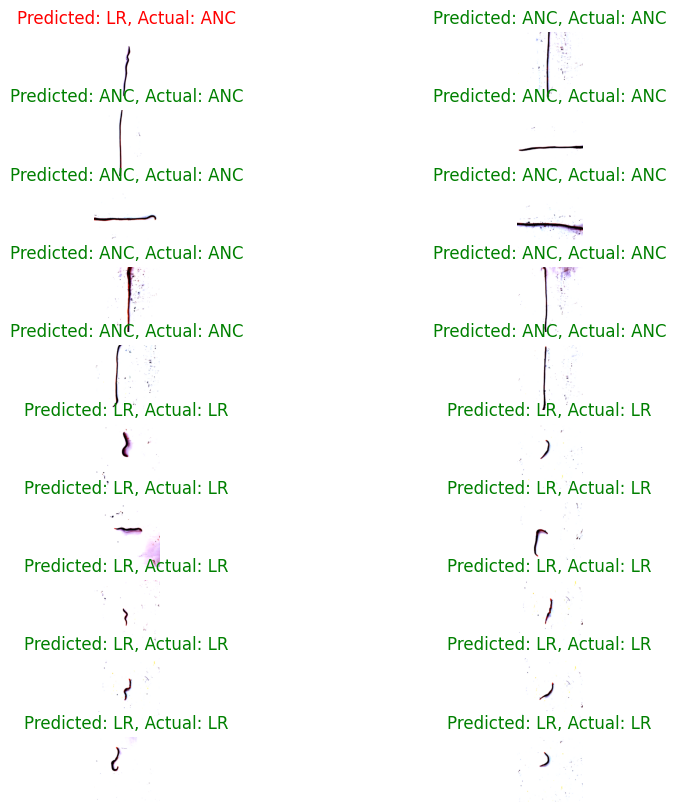

In [ ]:
# Function to visualize model predictions
def visualize_predictions(model, dataloader, dataset, num_images=len(test_dataset)):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))
    was_training = model.training  # Save the current training mode

    class_to_idx = dataset.class_to_idx
    idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                # Set title with color based on prediction correctness
                title_color = 'green' if preds[j] == labels[j] else 'red'
                pred_class = idx_to_class[preds[j].item()]
                actual_class = idx_to_class[labels[j].item()]
                ax.set_title(f'Predicted: {pred_class}, Actual: {actual_class}', color=title_color)

                # Display image with colormap based on prediction correctness
                image = inputs.cpu().data[j]
                if title_color == 'red':
                    ax.imshow(image.permute(1, 2, 0))
                else:
                    ax.imshow(image.permute(1, 2, 0), cmap='Greens')

                if images_so_far == num_images:
                    model.train(mode=was_training)  # Restore the training mode
                    return

# Visualize model predictions
visualize_predictions(model, test_loader, test_dataset, num_images=len(test_dataset))
plt.show()

# **Classification Report**

In [ ]:
from sklearn.metrics import classification_report

def get_all_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Get all predictions and labels
all_preds, all_labels = get_all_predictions(model, test_loader)

# Generate classification report
report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



# **Confusion Matrix**

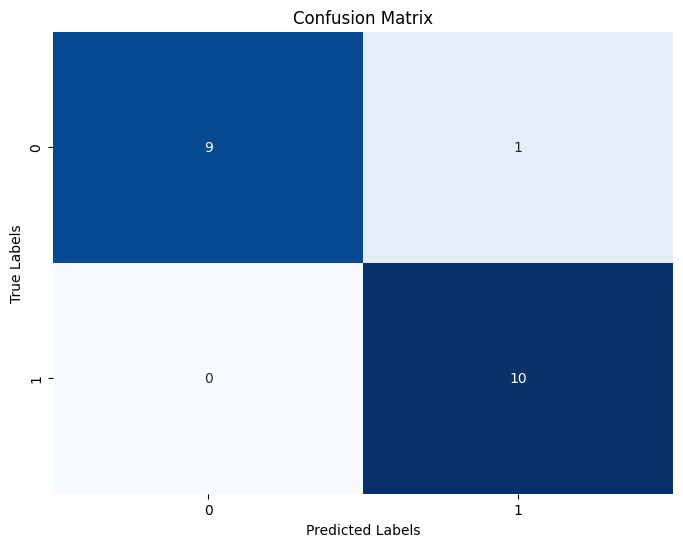

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()